# **Restaurants You Will Love**

**CSCE 670: Information Retrieval - Spring 2017** 


Shuocun Li, Ying Wang, Luxing Shen, Jiechen Zhong


## Overview and Motivation
Recommender system is to deliver proper items to users in order to improve user engagement and satisfaction. Collaborative filtering is the most frequently used method for recommender systems. The principal idea of Collaborative Filtering (CF) is similar items might be favored by similar groups of users and currently, existing CF methods measure such similarity over entire set of items.

However, users might share different interests over different topics, which means users might share similarities with different groups of users with respect to different sets of items. For example, a Yelp user might has similar tastes on Mexican food with a certain group of users, while has similar taste on the restaurant decoration style with different group of users. Considering these, in order to improve the performance of the recommender system, we try to improve the traditional CF to first cluster users and restaurants to subgroups. After that, we do traditional CF over each subgroup and aggregate the each sub-result to final recommendation.

# Data Process
The input data of this program is a group of reviews clustered by "word2vec" and these data should have overlapping, which means each individual user or restaurant can be assigned to different clusters. The notebook named "clustering" takes an input of 250 thousands reviews and clusters them into 9 clusters.

# Latent Factors + User & Item Bias
In this part, we use Latent Factor Model + User & Item bias to obtain "user-concept" and "item-concept" Matrices. We use Gradient Decent idea to train our model, which means our objective is to minimize the cost function:

$J(Q,P, b_{x}, b_{i})=min_{Q,P}\sum_{(x,i)\in R}(r_{xi}-(\mu+b_{x}+b_{i}+q_{i}p_{x}))^{2}+(\lambda_{1}\sum_{i}|q_{i}|^2+\lambda_{2}\sum_{x}|p_{x}|^2+\lambda_{3}\sum_{x}|b_{x}|^2+\lambda_{4}\sum_{i}|b_{i}|^2)$

For faster convergence, in this case, we apply Stochastic Gradient Decent to the Cost function $J(Q,P,b_{x},b_{i})$ and update each parameter $Q, P, b_{x}, b_{i}$ at each iteration. We get the following updating equation:

$\epsilon_{xi}=2(r_{xi}-q_{i}\cdot p_{x})$

$q_{i}=q_{i}+\mu_{1}(\epsilon_{xi}p_{x}-2\lambda_{2}q_{i})$

$p_{x}=p_{x}+\mu_{2}(\epsilon_{xi}q_{i}-2\lambda_{1}q_{x})$

$b_{x}\leftarrow b_{x}+\mu_{3}(\epsilon_{xi}-2\lambda_{3}b_{x})$

$b_{i}\leftarrow b_{i}+\mu_{4}(\epsilon_{xi}-2\lambda_{4}b_{i})$

For the training purpose, we randomly initialize the "user-concept" and "item-concept" matrices which just follow normal distribution. Empirically, we select the learning rate $\mu=0.005$, number of latent factors $k=20$ and the number of iteraiont $ite=15$. When it comes to regularization, as the regularization factor is basically intrinsic to avoid classic overfitting problem, we use a separate jupyter notebook named "parameter_tuning_baseline" to find the partial-optimal Regularization Factor corresponding to each cluster.



In [134]:
from nltk.stem.porter import PorterStemmer
import json
import re
import glob
import math
from numpy import *
import numpy as np
import matplotlib.pyplot as plt

In [135]:
## objectives
## 1. get the number of users & items in training data. Entry of matrix

## interface:
## input(1)
#    name of a file
## output(2)
#    user_id: a list of distinct users
#    business_id: a list of distinct restaurant

def matrix_entry(file_name):
    # get the size of user_id & business_id
    user_id = []
    business_id = []
    with open(file_name) as f:
        for line in f:
            temp = json.loads(line)        
            user_id.append(temp["user_id"])
            business_id.append(temp["business_id"])
    review_size = user_id.__len__()
    # This is without duplication: set
    user_id = list(set(user_id))
    business_id = list(set(business_id))
    return [user_id, business_id, review_size]

file_name = 'proj_data/cluster0.json'
[user_id, business_id, review_size] = matrix_entry(file_name)
print "Number of distinct users: " + str(user_id.__len__())
print "Number of distinc restaurants: " + str(business_id.__len__())
print "done"

Number of distinct users: 16122
Number of distinc restaurants: 1655
done


In [136]:
## Objectives
## 1. calculate the "Global Average" with variable name "average"
## 2. user bias of all users with variable name "origin_user_bias"
#     it is a dictionary = {user_id --> user average score}
#     intermedia variable: user_bias_list = {user_id --> a list of scores}
## 3. restaurant bias of all restaurants with variable name "origin_restaurant_bias"
#     it is a dictionary = {business_id --> restaurant averate score}
#     intermedia variable: business_bias_list = {business_id --> a list of scores}

## interface:
## input(3:
#    name of a file
#    user_id
#    business_id
#
## output(3):
#    global average
#    origin_user_bias
#    origin_business_bias
def baseline(file_name, user_id, business_id):
    average = 0
    num_star = 0
    user_bias_list = {}
    origin_user_bias = {}
    business_bias_list = {}
    origin_business_bias = {}
    for value in user_id:
        user_bias_list[value] = []
        origin_user_bias[value] = 0
    for value in business_id:
        business_bias_list[value] = []
        origin_business_bias[value] = 0

    # adding the list
    with open(file_name) as f:
        for line in f:
            # get the infor from file
            temp = json.loads(line)        
            cur_user_id = temp["user_id"]
            cur_business_id = temp["business_id"]
            star = temp["stars"]
            # filling the dictionary & calculate the average
            average += star
            num_star += 1
            user_bias_list[cur_user_id].append(star)
            business_bias_list[cur_business_id].append(star)

    # average
    average /= float(num_star)
    # calculate: user_bias = {user_id --> average score} & business_bias = {business_id --> average score}
    for user_key in user_bias_list:
        b_x = sum(user_bias_list[user_key]) / float(user_bias_list[user_key].__len__()) - average
        origin_user_bias[user_key] = b_x
    for business_key in business_bias_list:
        b_i = sum(business_bias_list[business_key]) / float(business_bias_list[business_key].__len__()) - average
        origin_business_bias[business_key] = b_i
    return [average, origin_user_bias, origin_business_bias]

file_name = 'proj_data/cluster0.json'
[average, origin_user_bias, origin_business_bias] = baseline(file_name, user_id, business_id)
print "done"

done


In [137]:
## Objective:
## 1. Make "user_id" and "business_id" in the data match the index in latent factor model

## interface
## input(2):
#    user_id
#    business_id
## output(2):
#    user_matching
#    business_matching

def matching(user_id, business_id):
    # user_id = list(user_id)
    user_idx = range(user_id.__len__())
    user_match = dict(zip(user_id, user_idx))

#     business_id = list(business_id)
    business_idx = range(business_id.__len__())
    business_match= dict(zip(business_id, business_idx))
    return [user_match, business_match]

[user_match, business_match] = matching(user_id, business_id)
print "done"

done


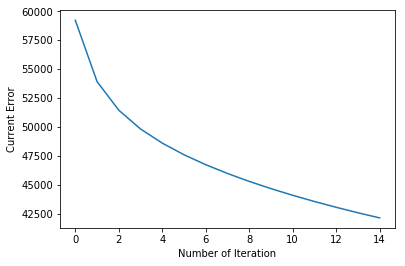

done


In [138]:
## Objective:
## 1. Sochastic Gradient Decent training function with bias

## SGD training function interface
## inputs(10):
#    file_name: training file
#    ite: number of iteration
#    lam: regulation factor: assume lam1 == lam2 == lam3 == lam4
#    mu: study rate: assume mu1 = mu2
#    k: number of concept in latent factor
#    m: number of users
#    n: number of items (restaurant)
#    user_match: from user_id to index i
#    business_match: from business_id to index j
#    user_bias & business_bias: should equal to "original user_bias & business_bias", whose values won't change
#    average: global average
## outputs(4):
#    latent factor q & p, updated user_bias & business_bias

def SGD_train(file_name, ite, lam, mu, k, m, n, user_match, business_match, user_bias, business_bias, average):
    # initialization
    q = np.random.rand(m, k) * sqrt(5.0 / k)  # normalization
    p = np.random.rand(n, k) * sqrt(5.0 / k)
    fig = empty(ite)

    ## essential steps
    # 1. read the file to get user_id, business_id, stars
    # 2. find the corresponding index of user_id, business_id in q and p
    # 3. Stochastic GD alg
    for num in range(0, ite):
#         print num
        # read the file to update q & p
        with open(file_name) as f:
            for line in f:
                temp = json.loads(line)
                cur_user_id = temp["user_id"]
                cur_business_id = temp["business_id"]
                # get initialized b_x, b_i
                b_x = user_bias[cur_user_id]
                b_i = business_bias[cur_business_id]
                i = user_match[cur_user_id]                  # get the index of corresponding user in q
                j = business_match[cur_business_id]          # get the index of corresponding business in p
                star = temp["stars"]
                # updating p, q, b_x & b_i
                eps = 2 * (star - (average + b_x + b_i + dot(q[i, ], p[j, ])))
                temp_q = q[i, ] + mu * (eps * p[j, ] - 2 * lam * q[i, ])
                temp_p = p[j, ] + mu * (eps * q[i, ] - 2 * lam * p[j, ])
                q[i, ] = temp_q
                p[j, ] = temp_p
                user_bias[cur_user_id] = b_x + mu * (eps - 2 * lam * b_x)
                business_bias[cur_business_id] = b_i + mu * (eps - 2 * lam * b_i)

        # uncomment the following code to get the plot
        # read the file to calculate the error
        error = 0
        with open(file_name) as f:
            for line in f:
                temp = json.loads(line)
                cur_user_id = temp["user_id"]
                cur_business_id = temp["business_id"]
                i = user_match[cur_user_id]
                j = business_match[cur_business_id]
                b_x = user_bias[cur_user_id]
                b_i = business_bias[cur_business_id] 
                star = temp["stars"]
                error += (star - (average + b_x + b_i + dot(q[i, ], p[j, ]))) ** 2
        # add the regulation error (combine them in all)
        # regulation for b_x & b_i
        regu_user_bias = 0
        regu_business_bias = 0
        for key in user_bias:
            regu_user_bias += user_bias[key] ** 2
        for key in business_bias:
            regu_business_bias += business_bias[key] ** 2
        error += lam * (sum(q ** 2) + sum(p ** 2) + regu_user_bias + regu_business_bias)
        fig[num] = error        

    # examine: plot the graph 
    plt.plot(range(0, ite), fig)
    plt.xlabel("Number of Iteration")
    plt.ylabel('Current Error')
    plt.show()
    return q, p, user_bias, business_bias

ite = 15                                  
lam = 0.2
lam = 0.7
mu = 0.005                                
k = 20   
m = user_id.__len__()                     
n = business_id.__len__()
train_file = 'proj_data/cluster0.json'
[q, p, user_bias, business_bias] = SGD_train(
        train_file, ite, lam, mu, k, m, n, user_match, business_match, origin_user_bias, origin_business_bias, average)
print "done"

# Explanation of Training Procedure
The overall procedure of Stochastic Gradient Algorithm training is show below: (We take 'cluster1' as an example)
    
First, we get the total number of distinct users & distinct restaurants, the number of distinct users is 16122 and the number of distinc restaurants is 1655. Afterwards, we calculate the "global average" of all the scores, average of user bias & average of business bias in this particular cluster. Finally, we train the model to obtain the optimal "user-to-concept" & "business-to-concept" matrices using tuned regularization factor. The result of training procedure is shown above, where x-axis represeting the number of iteration and the y-axis represent the entire error over the training set. It demonstrates a pretty good result as the error asymtotically approaches 0.

In [139]:
## Objective:
## 1. Sochastic Gradient Decent testing function with bias

## SGD testing function with baseline interface
## input(7):
#    file_name: testing file
#    q and p: learned latend factor model
#    user_match & business_match
#    user_bias & business_bias: learned bias
#    average
## output(1):
#    RMSE
def SGD_test(file_name, q, p, user_match, business_match, user_bias, business_bias, average):
    extrapolate_star = []
    origin_star = []
    size = 0
    RMSE = 0
    with open(file_name) as f:
        for line in f:
            temp = json.loads(line)
            cur_user_id = temp["user_id"]
            cur_business_id = temp["business_id"]
            # check if current review is in the Matrix
            if cur_user_id in user_match and cur_business_id in business_match:
                size += 1
                i = user_match[cur_user_id]
                j = business_match[cur_business_id]
                star = temp["stars"]
                b_x = user_bias[cur_user_id]
                b_i = business_bias[cur_business_id] 
                RMSE += (star - (average + b_x + b_i + dot(q[i, ], p[j, ]))) ** 2
        RMSE = sqrt(RMSE / float(size))    
    return RMSE

# Aggregation the final results
We have implemented CCCF-AVG algorithm as our aggregation method. The main idea of CCCF-AVG method is to combine predcited score for each user and restaurant appeared in each cluster, and take average of total summation score, as shown in formula 1.$$\hat{y_{ui}}=\sum_{k}{\hat{y_{ui}^{k}}/K} \quad \text{$${1}$$}$$ For each individual user and restaurant in each cluster, we have calculated its user bias, bussiness bias, latent factor matrix, and the predicted score is based on formula 2. $${y_{ui}}=\mu+b_x+b_i+p*q \quad \text{$${2}$$}$$

In [140]:
## single cluster creation
## structure of singleCluster: list --> [q, p, user_bias, business_bias, user_match, business_match, cur_average]
def singleCluster(file_name, lam):
    # get the user_id & business_id in a file
    [user_id, business_id, review_size] = matrix_entry(file_name)
    # get the matching 
    [user_match, business_match] = matching(user_id, business_id)
    # calculate its corresponding baseline
    [average, user_bias, business_bias] = baseline(file_name, user_id, business_id)
    
    # set the parameter
    ite = 15                                  
    mu = 0.005                                
    k = 20                                    
    m = user_id.__len__()                     
    n = business_id.__len__()  
    
    # SGD training 
    [q, p, user_bias, business_bias] = SGD_train(
        file_name, ite, lam, mu, k, m, n, user_match, business_match, user_bias, business_bias, average)
    # current cluster
    cur_cluster = []
    cur_cluster.append(q)
    cur_cluster.append(p)
    cur_cluster.append(user_bias)
    cur_cluster.append(business_bias)
    cur_cluster.append(user_match)
    cur_cluster.append(business_match)
    cur_cluster.append(average)
    cur_cluster.append(1 / float(review_size))
    return cur_cluster
    
# implement the method
# file_name = 'yelp_data/training_at5.json'
# file_name = "proj_data/cluster9.json"
# cur_lam = 0.2
# single_cluster = singleCluster(file_name, cur_lam)
print "done"

done


0


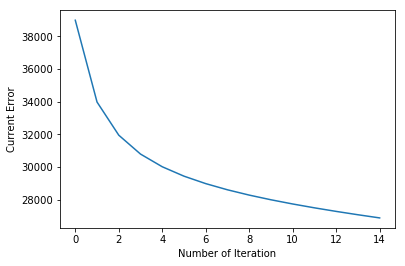

1


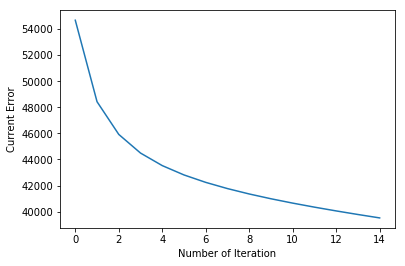

2


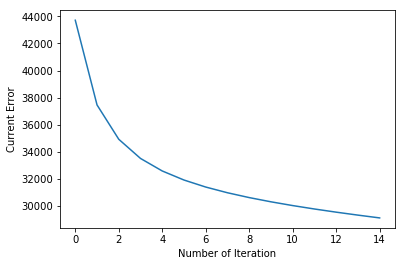

3


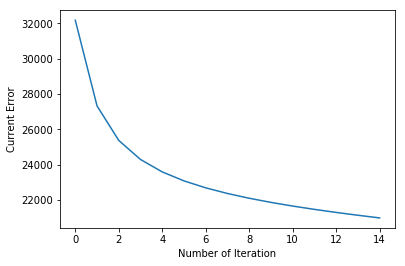

4


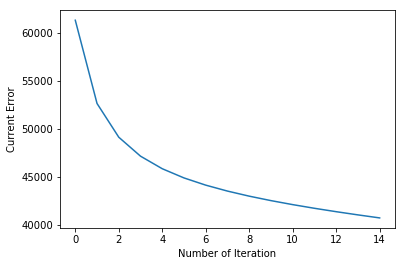

5


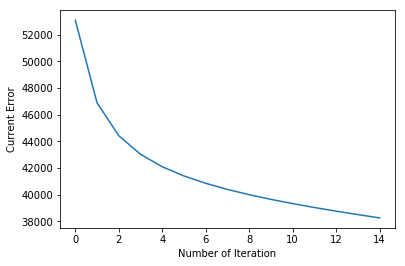

6


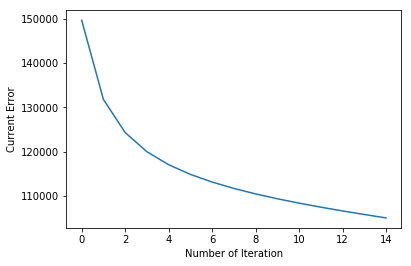

7


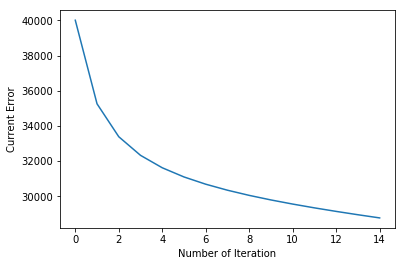

done


In [141]:
## multiple clusters
def multiCluster(directory):
    cluster_data = {}
    cluster_key = 0
    for file_name in glob.glob(directory):
        print cluster_key
        # create a dictionary for cluster
        cur_lam = 0.2
        cluster_data[cluster_key] = singleCluster(file_name, cur_lam)
        cluster_key += 1
    return cluster_data

directory = 'proj_data/*.json'
all_cluster = multiCluster(directory)
print "done"        

In [142]:
# get the global user_id & business_id, which is designed for testing
file_name = 'yelp_data/training_at5.json'
[global_user_id, global_business_id, review_size] = matrix_entry(file_name)
print "done"

done


In [143]:
##aggregation test
def aggregation_avg(file_name, cluster, global_userid, global_bussiness_id):
    numOfTest = 0
    RMSE = 0
    with open(file_name) as f:
        for line in f:
            temp = json.loads(line)
            cur_user_id = temp["user_id"]
            cur_business_id = temp["business_id"]

            m = 0
            num = 0
            if cur_user_id in global_userid and cur_business_id in global_bussiness_id:
                star = temp["stars"]
                for x in range(0, cluster.__len__()):
                    if cur_user_id in cluster[x][4] and cur_business_id in cluster[x][5]:
                        num += 1

                        i = cluster[x][4][cur_user_id]
                        j = cluster[x][5][cur_business_id]
                        b_x = cluster[x][2][cur_user_id]
                        b_i = cluster[x][3][cur_business_id] 
                        temp_average = cluster[x][6] 
                        m += temp_average + b_x + b_i + dot(cluster[x][0][i, ], cluster[x][1][j, ])
                
                # just for corner case
                if num != 0:
                    numOfTest += 1
                    score = m / num
                    RMSE += (star - score) ** 2
        
        print numOfTest        
        RMSE = sqrt(RMSE / float(numOfTest))    
    return RMSE
print "done"

done


In [144]:
## test method
test_file = 'yelp_data/testing_at5.json'
RMSE = aggregation_avg(test_file, all_cluster, global_user_id, global_business_id)

print RMSE
print "average done"

25372
1.16388151053
average done


# Comparison between Latent Factor + Bias Model and CCCF
In this project, we implement the Co-Clusering Collaborative Filtering (CCCF), firstly, by separating the original data into many overlapping groups, and afterwards, apply biased Latent Factor Model to each individual cluster. Finally, we aggregate the final score using average aggregation. The final result is $RMSE = 1.163$ shown above.  Unfortunately, this is a negative optimization compared to original biased Latent Factor Model we calcuated on notebook "parameter_tuning_baseline" (Currently, the file takes the overall input with about 250 thousands reviews and each row and column contains more than 5 scores.). I believe this negative opitimization is induced by fewer reviews within single cluster containing a small part of restaurants. In that case, for each user, there are only a small part of training set and, liberately, the training result will be negative optimization, , which could be regarded as a cold start problem. 
# Future Improvement
In the future, I believe more effort should be devoted onto the data within each cluster to ensure that the "Cold Start" problem will never occur in single cluster, which means the extrapolating rating within each cluster is optimized.
